In [134]:
import numpy as np 
import torch, matplotlib
import matplotlib.pyplot as plt 

from utils import *

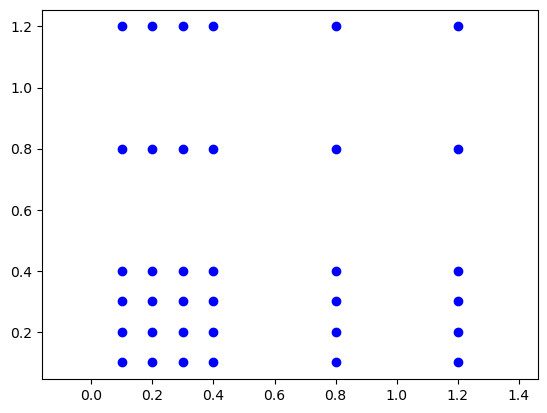

In [135]:
lamda = 0.2
min_distance = 0.1
levels_horizontal = [3, 3]
levels_vertical = [3, 3]
nbSensors = sum(levels_horizontal) * sum(levels_vertical)

array = NestedArray2D(lamda, min_distance, levels_horizontal, levels_vertical)
array.plot()

In [136]:
d = 10
t = 200
snr = 20

phi = torch.rand(d) * torch.pi
theta = torch.rand(d) * torch.pi / 2

source_std = torch.eye(d, dtype=torch.complex64)
noise_std = torch.sqrt(torch.sum(torch.diag(source_std) ** 2)) * 10 ** (-snr/20)

X = array.get_steering_vector(phi, theta) @ source_std @ torch.randn(d, t, dtype=torch.complex64) / sqrt(2) \
  + noise_std * torch.randn(nbSensors, t) / sqrt(2)

In [137]:
cov = X @ X.T.conj() / t
cov_vec = cov.flatten()

index1 = torch.Tensor([[i, j] for i in range(len(array.pos_horizontal)) for j in range(len(array.pos_horizontal))]).int()
dist1 = torch.Tensor([i - j for i in array.pos_horizontal for j in array.pos_horizontal])
vals1, idx1 = torch.sort(dist1)

first_occurence_index_x = []
min_idx = idx1[0]
for i in range(1, vals1.shape[0]):
    if vals1[i] == vals1[i - 1]:
        min_idx = min(min_idx, idx1[i])
    else:
        first_occurence_index_x.append(min_idx)
        min_idx = idx1[i]
first_occurence_index_x.append(min_idx)
first_occurence_index_x = torch.stack(first_occurence_index_x)
index1 = index1[first_occurence_index_x]

index2 = torch.Tensor([[i, j] for i in range(len(array.pos_vertical)) for j in range(len(array.pos_vertical))]).int()
dist2 = torch.Tensor([i - j for i in array.pos_vertical for j in array.pos_vertical])
vals2, idx2 = torch.sort(dist2)

first_occurence_index_y = []
min_idx = idx2[0]
for i in range(1, vals2.shape[0]):
    if vals2[i] == vals2[i - 1]:
        min_idx = min(min_idx, idx2[i])
    else:
        first_occurence_index_y.append(min_idx)
        min_idx = idx2[i]
first_occurence_index_y.append(min_idx)
first_occurence_index_y = torch.stack(first_occurence_index_y)
index2 = index2[first_occurence_index_y]

index1 = index1.repeat(2 * array.pos_horizontal[-1] - 2 * array.pos_horizontal[0] + 1, 1)
index2 = index2.repeat_interleave(2 * array.pos_vertical[-1] - 2 * array.pos_vertical[0] + 1, 0)
index = (index1[:, 0] + index2[:, 0] * len(array.pos_vertical)) * len(array.pos_horizontal) * len(array.pos_vertical) \
       + index1[:, 1] + index2[:, 1] * len(array.pos_horizontal) 

z = cov_vec[index]

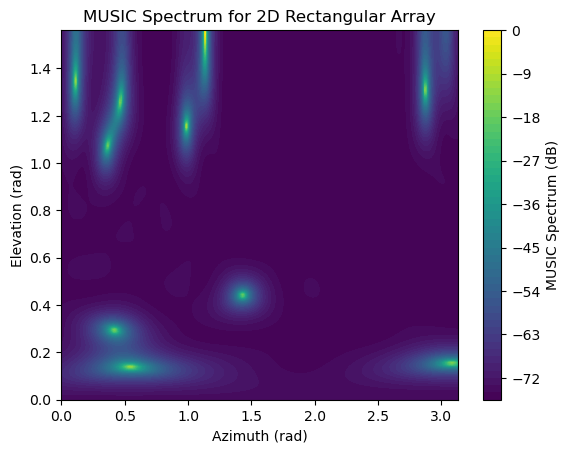

In [138]:
len_horizontal = array.pos_horizontal[-1] - array.pos_horizontal[0] + 1
len_vertical = array.pos_vertical[-1] - array.pos_vertical[0] + 1
coarray = URA(lamda, min_distance, len_horizontal, len_vertical)
coarray.build_array_manifold()

cov_smooth = torch.zeros(len_horizontal * len_vertical, len_horizontal * len_vertical, dtype=torch.complex64)
for i in range(len_horizontal):
    for j in range(len_vertical):
        idx = [(i + k) + (2 * len_horizontal - 1) * (j + l) for l in range(len_vertical) for k in range(len_horizontal)]
        cov_smooth += z[idx].reshape(-1, 1) * z[idx].reshape(1, -1).conj()
cov_smooth /= (len_horizontal * len_vertical)

_, vecs = torch.linalg.eigh(cov_smooth)
En = vecs[:, :-d]

spectrum = 1 / torch.norm(torch.einsum('mi,mjk->ijk', En.conj(), coarray.array_manifold), dim=0) ** 2

phi_space, theta_space = np.meshgrid(coarray.phi_space, coarray.theta_space)
spectrum = 10 * torch.log(spectrum / torch.max(spectrum))

plt.contourf(phi_space, theta_space, spectrum, levels=50, cmap='viridis')
plt.colorbar(label='MUSIC Spectrum (dB)')
plt.xlabel('Azimuth (rad)')
plt.ylabel('Elevation (rad)')
plt.title('MUSIC Spectrum for 2D Rectangular Array')
plt.show()